In [159]:
# There are two ways of Transfer Learning
# 1. Finetuning the ConvNet: Get pretrained network(i.e. resnet18), then train with new data
#    Not starting with random initialization, but with pretrained weights
# 2. ConvNet as fixed feature extractor: Freeze all weights of networks except,
#    final fully connected layer. Newly replaced final FC layer is randomly initialized
#    and only this FC layer is trained

In [15]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from PIL import Image

plt.ion()   # interactive mode

In [5]:
GPU_NUM = 0 # 원하는 GPU 번호 입력
device = torch.device(f'cuda:{GPU_NUM}' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device) # change allocation of current GPU
print ('Current cuda device ', torch.cuda.current_device()) # check

# Additional Infos
if device.type == 'cuda':
    print(torch.cuda.get_device_name(GPU_NUM))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(GPU_NUM)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(GPU_NUM)/1024**3,1), 'GB')

Current cuda device  0
GeForce GTX 1660 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


C:\Users\Dustin Baek\.conda\envs\myenv\lib\site-packages\torch\cuda\memory.py:344: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  warnings.warn(


In [121]:
# use data_transform to change PIL image to tensor using transforms.ToTensor()
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                         data_transforms[x])
                  for x in ['train', 'val']}
# for i in range(len(image_datasets['train'])):
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes

# dataloaders['train']
# image_datasets['train'][1][0]
# print(class_names)


['ants', 'bees']


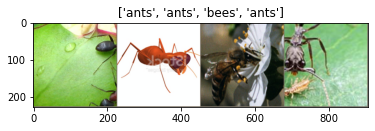

In [127]:
'''how to visualize dataloader'''
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
#     import pdb; pdb.set_trace()
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [136]:
a=torch.rand(4,4)
print(a)
b,c=torch.max(a,dim=1)
print(c)


tensor([[0.7353, 0.2350, 0.4436, 0.4169],
        [0.1313, 0.3500, 0.0837, 0.9049],
        [0.2824, 0.6775, 0.8587, 0.6930],
        [0.8062, 0.9835, 0.5602, 0.6067]])
tensor([0, 3, 2, 1])


In [152]:
a=torch.tensor([1,0,1,0,1])
b=torch.tensor([0,0,1,0,1])
k=torch.sum(a==b)
k.item()

4

In [153]:
'''1. Finetuning the ConvNet'''


def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    '''best model 저장하는방식이 신기하네'''
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [154]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [155]:
'''Fine-tuning existing models - Transfer Learning'''
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to C:\Users\Dustin Baek/.cache\torch\hub\checkpoints\resnet18-5c106cde.pth


In [156]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6117 Acc: 0.6749
val Loss: 0.1994 Acc: 0.9346

Epoch 1/24
----------
train Loss: 0.5463 Acc: 0.7737
val Loss: 0.2578 Acc: 0.9150

Epoch 2/24
----------
train Loss: 0.6422 Acc: 0.7572
val Loss: 0.2721 Acc: 0.9020

Epoch 3/24
----------
train Loss: 0.6831 Acc: 0.7531
val Loss: 0.5226 Acc: 0.8366

Epoch 4/24
----------
train Loss: 0.4146 Acc: 0.8313
val Loss: 0.1879 Acc: 0.9281

Epoch 5/24
----------
train Loss: 0.5967 Acc: 0.7737
val Loss: 0.4428 Acc: 0.8235

Epoch 6/24
----------
train Loss: 0.5231 Acc: 0.7860
val Loss: 0.2487 Acc: 0.8889

Epoch 7/24
----------
train Loss: 0.4559 Acc: 0.8272
val Loss: 0.2167 Acc: 0.9150

Epoch 8/24
----------
train Loss: 0.3119 Acc: 0.8519
val Loss: 0.2960 Acc: 0.8954

Epoch 9/24
----------
train Loss: 0.3114 Acc: 0.8601
val Loss: 0.2305 Acc: 0.9085

Epoch 10/24
----------
train Loss: 0.3022 Acc: 0.8930
val Loss: 0.2534 Acc: 0.8954

Epoch 11/24
----------
train Loss: 0.2720 Acc: 0.8930
val Loss: 0.2167 Acc: 0.9281

Ep

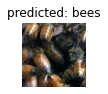

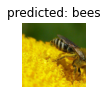

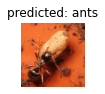

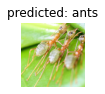

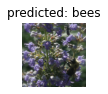

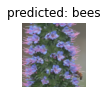

In [158]:
visualize_model(model_ft)


In [160]:
'''2. ConvNet as fixed feature extractor'''
# Here, we need to freeze all the network except the final layer. 
# We need to set requires_grad == False 
# to freeze the parameters so that the gradients are not computed in backward().

model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

    '''Important'''
# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [161]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5747 Acc: 0.6914
val Loss: 0.2785 Acc: 0.8889

Epoch 1/24
----------
train Loss: 0.5150 Acc: 0.7654
val Loss: 0.2115 Acc: 0.9477

Epoch 2/24
----------
train Loss: 0.4569 Acc: 0.8066
val Loss: 0.2108 Acc: 0.9216

Epoch 3/24
----------
train Loss: 0.4720 Acc: 0.7860
val Loss: 0.1999 Acc: 0.9281

Epoch 4/24
----------
train Loss: 0.7909 Acc: 0.7160
val Loss: 0.2477 Acc: 0.9020

Epoch 5/24
----------
train Loss: 0.3182 Acc: 0.8765
val Loss: 0.1785 Acc: 0.9412

Epoch 6/24
----------
train Loss: 0.5035 Acc: 0.8066
val Loss: 0.2220 Acc: 0.9412

Epoch 7/24
----------
train Loss: 0.4572 Acc: 0.8025
val Loss: 0.1851 Acc: 0.9477

Epoch 8/24
----------
train Loss: 0.2942 Acc: 0.8889
val Loss: 0.1789 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.4430 Acc: 0.7984
val Loss: 0.1743 Acc: 0.9542

Epoch 10/24
----------
train Loss: 0.2734 Acc: 0.8765
val Loss: 0.1908 Acc: 0.9477

Epoch 11/24
----------
train Loss: 0.3342 Acc: 0.8560
val Loss: 0.1906 Acc: 0.9477

Ep

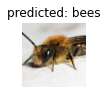

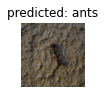

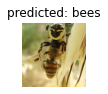

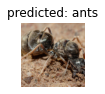

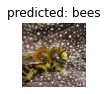

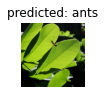

In [162]:
visualize_model(model_conv)

plt.ioff()
plt.show()